# Pedestrian Crash - Classification

In this attempt, i am splitting the HIC15 in ranges.
- Each range will have equal number of items.
- The number of ranges (bins) are 8.

## Importing the libraries

In [1]:
from pathlib import Path
import sys

sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src")
sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src\\src")
from src.dataset_reader import DatasetReaderCSV
from src.utilities import to_scrollable_table
from src.plot import plot_car_attributes_onehot, plot_pedestrian_attributes, plot_validation_acc_values, plot_hic15_max_binned
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.

In [2]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_2\\crash_simulation_classification.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Position"], errors="ignore")

In [3]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
df = df.drop(columns=to_remove_features)

In [4]:
from car_profile_expand import expand_car_profiles

df = df.apply(expand_car_profiles, axis=1)


In [5]:
# Print 10 random rows from the DataFrame
df.sample(n=10)

,CarProfile,Velocity,Translation,Rotation,HIC15_max,Bumber_Height,Front_Hood_Height,Bumber_Hood_Angle,Hood_Length,Back_Hood_Height
837,RDS,60,400,330,2787.676,500,680,20,1200,920
462,MPV,40,200,270,33003.927,600,880,30,760,1070
1196,SUV,80,400,30,140.360,580,900,11,1160,1130
992,SUV,20,0,30,87.689,580,900,11,1160,1130
958,SUV,100,400,60,1253.029,580,900,11,1160,1130
435,MPV,40,-400,180,88.270,600,880,30,760,1070
757,RDS,40,200,120,16906.589,500,680,20,1200,920
260,FCR,80,-400,30,912.845,770,740,16,1150,980
73,FCR,20,-400,120,1751.797,770,740,16,1150,980
390,MPV,20,0,270,29344.507,600,880,30,760,1070


## Dataset Modifications

### One-hot-encoding in CarProfile column

In [6]:
# One-hot encoding the 'CarProfile' column
df = pd.get_dummies(df, columns=['CarProfile'])

# Display the DataFrame after one-hot encoding
print("\nDataFrame after One-hot Encoding:")
print(df)


DataFrame after One-hot Encoding:
      Velocity  Translation  Rotation  HIC15_max  Bumber_Height  \
0          100         -200         0     86.843            770   
1          100         -200       120   2361.697            770   
2          100         -200       150    573.455            770   
3          100         -200       180     84.702            770   
4          100         -200       210    592.965            770   
...        ...          ...       ...        ...            ...   
1195        80          400       300    623.367            580   
1196        80          400        30    140.360            580   
1197        80          400       330    367.018            580   
1198        80          400        60   1317.014            580   
1199        80          400        90   1861.807            580   

      Front_Hood_Height  Bumber_Hood_Angle  Hood_Length  Back_Hood_Height  \
0                   740                 16         1150               980   
1     

### Separate the HIC15_max column values into bin ranges from Q1 to Q8

In [7]:
NUM_OF_BINS = 8
# Create quantile bins
y_binned, bin_edges = pd.qcut(df['HIC15_max'], q=NUM_OF_BINS, labels=[f'Q{i+1}' for i in range(NUM_OF_BINS)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Add the binned variable as a new column to the DataFrame
df['HIC15_max_binned'] = y_binned
df = df.drop(columns=["HIC15_max"], errors="ignore")

# Now dfn_regr has the binned column
print(df.head())

# Print the count of each distinct value of HIC15_max_binned
print("\nCount of each distinct value of HIC15_max_binned:")
print(df['HIC15_max_binned'].value_counts().sort_index())

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
   Velocity  Translation  Rotation  Bumber_Height  Front_Hood_Height  \
0       100         -200         0            770                740   
1       100         -200       120            770                740   
2       100         -200       150            770                740   
3       100         -200       180            770                740   
4       100         -200       210            770                740   

   Bumber_Hood_Angle  Hood_Length  Back_Hood_Height  CarProfile_FCR  \
0                 16         1150               980            True   
1                 16         1150               980            True   
2                 16         1150               980            Tr

## Dataset Insights

### Dataset Head

In [8]:
# Print 10 random rows from the DataFrame
df.sample(n=10)

,Velocity,Translation,Rotation,Bumber_Height,Front_Hood_Height,Bumber_Hood_Angle,Hood_Length,Back_Hood_Height,CarProfile_FCR,CarProfile_MPV,CarProfile_RDS,CarProfile_SUV,HIC15_max_binned
337,100,200,120,600,880,30,760,1070,False,True,False,False,Q8
895,80,400,300,500,680,20,1200,920,False,False,True,False,Q5
788,60,-200,30,500,680,20,1200,920,False,False,True,False,Q7
703,20,200,300,500,680,20,1200,920,False,False,True,False,Q6
356,100,400,30,600,880,30,760,1070,False,True,False,False,Q7
569,80,0,240,600,880,30,760,1070,False,True,False,False,Q7
1020,40,-200,0,580,900,11,1160,1130,False,False,False,True,Q2
181,60,-200,120,770,740,16,1150,980,True,False,False,False,Q5
217,60,200,120,770,740,16,1150,980,True,False,False,False,Q5
1177,80,200,120,580,900,11,1160,1130,False,False,False,True,Q5


### Dataset description

In [9]:
print(df.describe())

          Velocity  Translation     Rotation  Bumber_Height  \
count  1200.000000  1200.000000  1200.000000    1200.000000   
mean     60.000000     0.000000   165.000000     612.500000   
std      28.296064   282.960637   103.604754      98.370799   
min      20.000000  -400.000000     0.000000     500.000000   
25%      40.000000  -200.000000    82.500000     560.000000   
50%      60.000000     0.000000   165.000000     590.000000   
75%      80.000000   200.000000   247.500000     642.500000   
max     100.000000   400.000000   330.000000     770.000000   

       Front_Hood_Height  Bumber_Hood_Angle  Hood_Length  Back_Hood_Height  
count        1200.000000        1200.000000  1200.000000        1200.00000  
mean          800.000000          19.250000  1067.500000        1025.00000  
std            92.774849           6.980552   178.592635          80.81115  
min           680.000000          11.000000   760.000000         920.00000  
25%           725.000000          14.750000  10

### Dataset table

In [10]:
to_scrollable_table(df)

Velocity,Translation,Rotation,Bumber_Height,Front_Hood_Height,Bumber_Hood_Angle,Hood_Length,Back_Hood_Height,CarProfile_FCR,CarProfile_MPV,CarProfile_RDS,CarProfile_SUV,HIC15_max_binned
100,-200,0,770,740,16,1150,980,True,False,False,False,Q1
100,-200,120,770,740,16,1150,980,True,False,False,False,Q5
100,-200,150,770,740,16,1150,980,True,False,False,False,Q3
100,-200,180,770,740,16,1150,980,True,False,False,False,Q1
100,-200,210,770,740,16,1150,980,True,False,False,False,Q3
100,-200,240,770,740,16,1150,980,True,False,False,False,Q4
100,-200,270,770,740,16,1150,980,True,False,False,False,Q6
100,-200,300,770,740,16,1150,980,True,False,False,False,Q6
100,-200,30,770,740,16,1150,980,True,False,False,False,Q3
100,-200,330,770,740,16,1150,980,True,False,False,False,Q2


### Car profile attributes

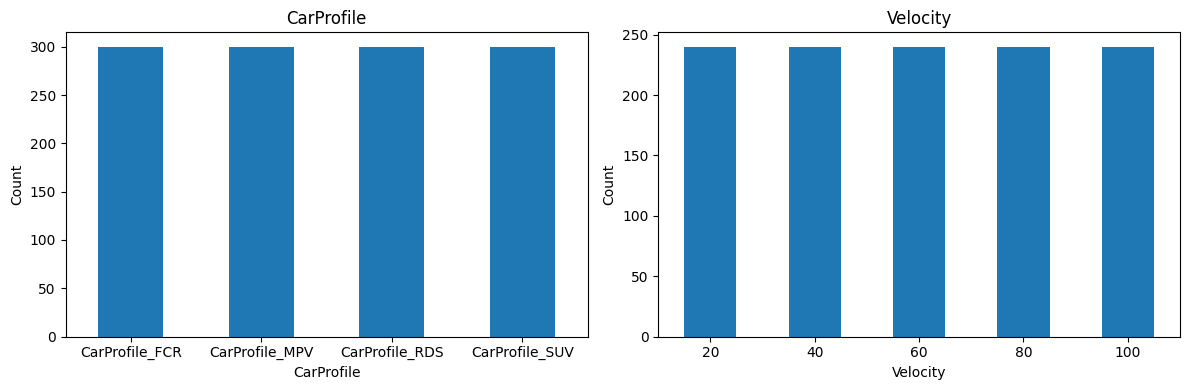

In [11]:
plot_car_attributes_onehot(df)

### Pedestrian attributes

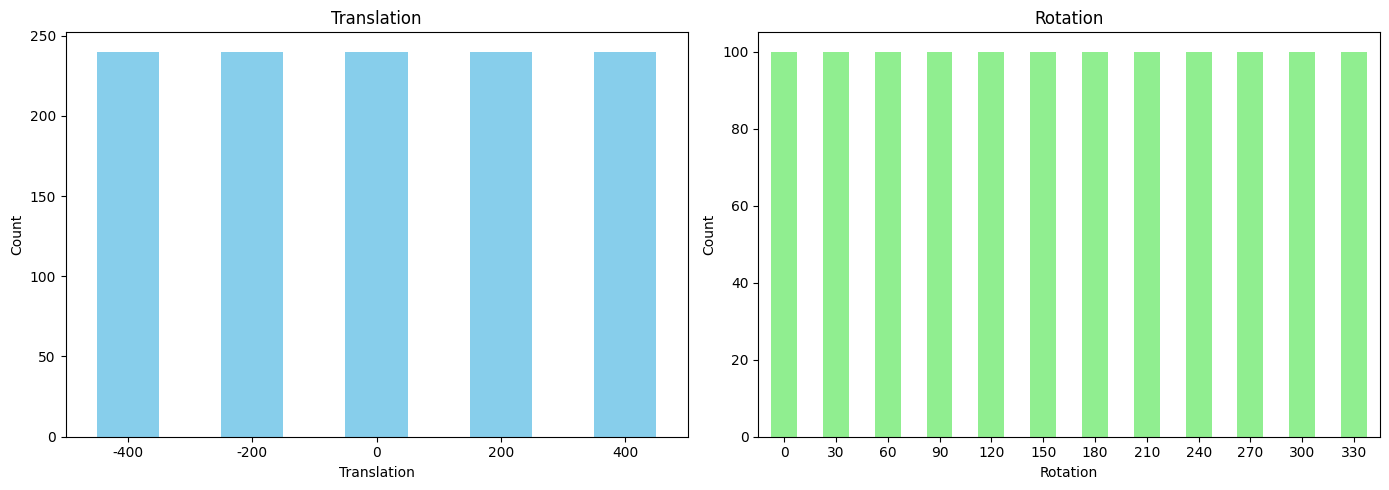

In [12]:
plot_pedestrian_attributes(df)

### Target attributes

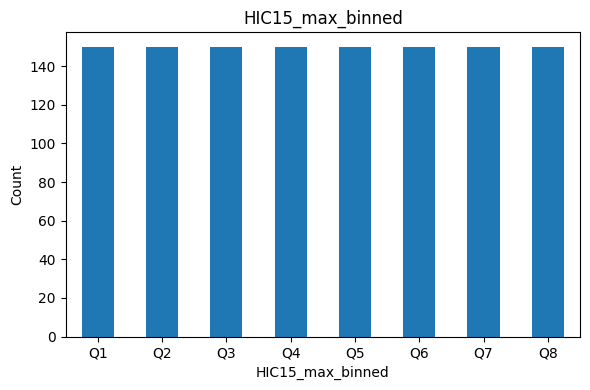

In [13]:
plot_hic15_max_binned(df)


## Perform classification on multiple targets

C:\Users\geork\AppData\Local\Temp\ipykernel_4312\3824685080.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1521 - loss: 2.6172
Epoch 1: val_loss improved from inf to 2.27653, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_2\model_5_2_2.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1569 - loss: 2.6097 - val_accuracy: 0.3167 - val_loss: 2.2765
Epoch 2/200
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3593 - loss: 2.1572
Epoch 2: val_loss improved from 2.27653 to 2.05067, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_2\model_5_2_2.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3578 - loss: 2.1559 - val_accuracy: 0.3667 - val_loss: 2.0507
Epoch 3/200
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3380 - loss: 1.9860
Epoch 3: val_loss improved from 2.05067 to 1.93761, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_2\5_2_2\model_5_2_2.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accura

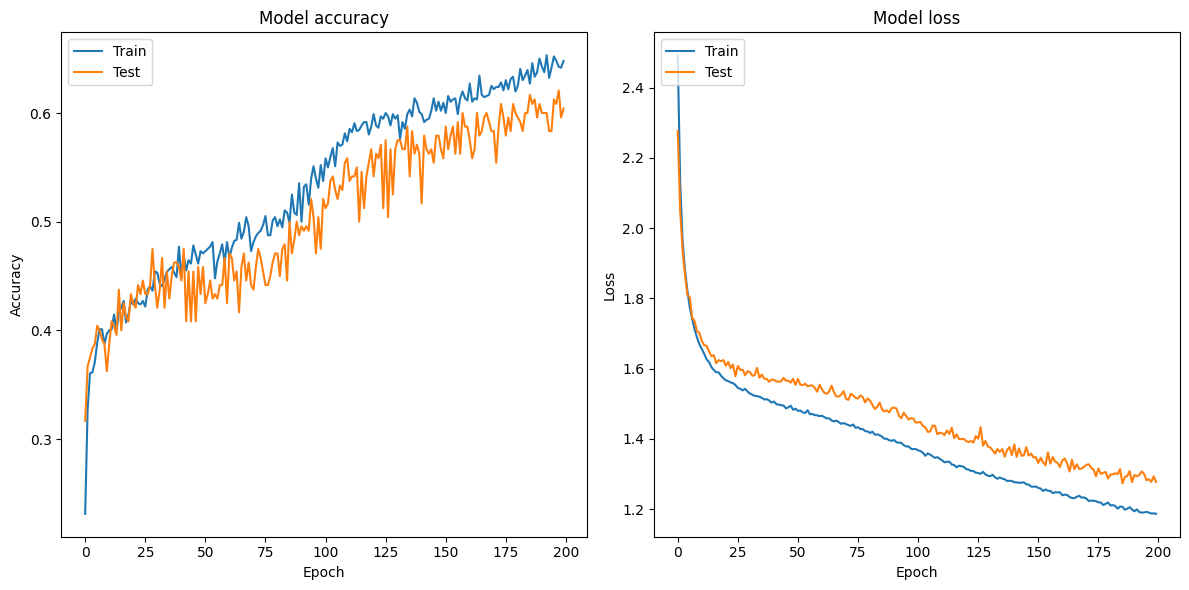

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


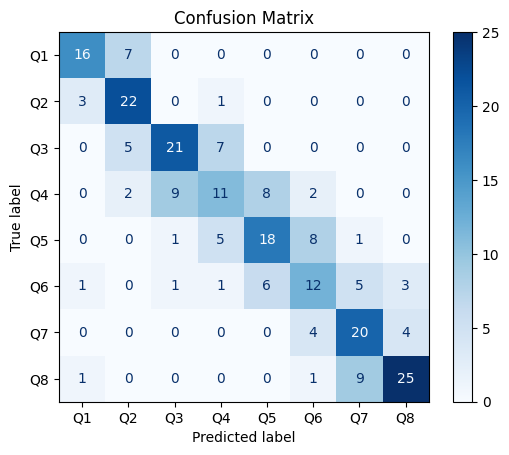

: 

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

# Encode target labels
label_encoder = LabelEncoder()
df['HIC15_max_binned'] = label_encoder.fit_transform(df['HIC15_max_binned'])

# Split features and target
X = df.drop(columns=['HIC15_max_binned'])
y = df['HIC15_max_binned']

# Convert boolean columns to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the neural network model
# model = Sequential()
# model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification

# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
filepath = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_2\\5_2_2\\model_5_2_2.keras")
# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                              save_best_only=True, mode='min', verbose=1)

#early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
# Train the model
#history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_data=(X_test, y_test))

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=200, batch_size=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=[
                        checkpoint, 
                        #early_stopping
                        ])

# Load the best model
best_model = load_model(filepath)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Test Accuracy: {accuracy * 100:.2f}%')

plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()